In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision

In [0]:
import numpy as np
import gzip
import struct
import pickle
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import transforms

In [445]:
import urllib.request

urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "train_features.gz")
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "test_features.gz")


def get_features(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
def plot_image(image):
    plt.imshow(image.reshape((28,28)), cmap="gray")
    
features = get_features("train_features.gz").reshape((60000, 784)) / 255
features = torch.from_numpy(features).float().cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [0]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    #encoder
    self.e_cnn1 = nn.Linear(784,600)
    self.e_act1 = nn.ReLU()
    self.e_cnn2 = nn.Linear(600,500)
    self.e_act2 = nn.ReLU()
    self.e_cnn3 = nn.Linear(500,484)
    self.e_act3 = nn.ReLU()
    self.e_dense_mean = nn.Linear(484, 20)
    self.e_dense_var = nn.Linear(484, 20)
    self.e_act4 = nn.ReLU()
    
    #decoder
    self.d_dense1 = nn.Linear(20,484)
    self.d_act1 = nn.ReLU()
    self.d_dense2 = nn.Linear(484, 784)
    self.d_act2 = nn.Sigmoid()
  
  def forward(self, input, generating=False):
    # encoding
    mean, var = None, None
    if not generating: 
      res = self.e_act1(self.e_cnn1(input))
      res = self.e_act2(self.e_cnn2(res))
      res = self.e_act3(self.e_cnn3(res))
      res = res.reshape(input.shape[0], 484)
      mean = self.e_act4(self.e_dense_mean(res))
      var = self.e_act4(self.e_dense_var(res))
      samples = torch.randn_like(var)
      input = mean + torch.exp(var*0.5)*samples
    
    # decoding
    res = self.d_act1(self.d_dense1(input))
    res = self.d_act2(self.d_dense2(res))
    return (res,mean,var)

In [0]:
net = VAE().cuda()

In [451]:
epochs = 500

optimizer = optim.Adam(net.parameters(), lr=1e-3)

for i in range(epochs):
  generated, mean, var = net(features)
  loss_reconstruct = (((features.reshape(60000,784) - generated) ** 2)).sum() / 60000
  loss_KL = (1 + var - mean.pow(2) - var.exp()).mean() * -0.5
  loss = loss_reconstruct + (loss_KL * 0.3)
  loss.backward()
  optimizer.step()
  print("epoch: ", i)
  print("reconstruct loss: ", loss_reconstruct.item())
  print("KL: ", loss_KL.item())
  print("___________")

epoch:  0
reconstruct loss:  182.8379669189453
KL:  0.00044071959564462304
___________
epoch:  1
reconstruct loss:  167.25213623046875
KL:  0.0016085964161902666
___________
epoch:  2
reconstruct loss:  153.1825714111328
KL:  0.0068311565555632114
___________
epoch:  3
reconstruct loss:  139.52633666992188
KL:  0.024560747668147087
___________
epoch:  4
reconstruct loss:  125.0968017578125
KL:  0.08030878007411957
___________
epoch:  5
reconstruct loss:  108.28643798828125
KL:  0.2475879192352295
___________
epoch:  6
reconstruct loss:  89.67294311523438
KL:  0.7373341917991638
___________
epoch:  7
reconstruct loss:  75.88555145263672
KL:  2.3105719089508057
___________
epoch:  8
reconstruct loss:  73.47452545166016
KL:  10.967930793762207
___________
epoch:  9
reconstruct loss:  76.68791198730469
KL:  137.12489318847656
___________
epoch:  10
reconstruct loss:  74.36796569824219
KL:  33.97178649902344
___________
epoch:  11
reconstruct loss:  71.75403594970703
KL:  13.086362838745117

torch.Size([1, 1, 28, 28])

In [0]:
from matplotlib import pyplot as plt
def plot_image(image):
    plt.imshow(image.detach().cpu().numpy().reshape((28,28)) * 255, cmap="gray")

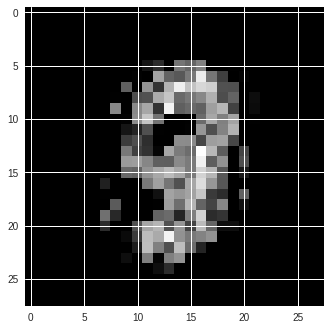

In [458]:
sample = net(torch.randn(20).cuda(), generating=True)[0]
plot_image(sample)